## News Mood
##### By: Mike Suomi, 6/29/18

- Observable Trend 1: BBC North America (different from BBC, but I thought more comparative to all the other US-based news networks) doesn't tweet out nearly as frequently as the other news organization, so to get 100 of their tweets they go back a lot further in time, whence the clustering towards the left of the x-axis in the scatter plot.
- Observable Trend 2:  Sentiments change pretty frequently, I've run this multiple times and it is always changing. However, one constant is that most of the news agencies at any one time are in the negative range - at most, I've had only one of the five go to positive at any one time.
- Observable Trend 3: The vader sentiments analysis isn't all that good (and/or getting sentiments is very complicated) because even spot checking some of the tweets that have gotten neutral didn't always really seem neutral.  One article I recall from NYTimes was how hospitals were failing to serve patients well and somehow that got a neutral sentiment.


#### Instructions
In this assignment, you'll create a Python script to perform a sentiment analysis of the Twitter activity of various news outlets, and to present your findings visually.

Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: **BBC, CBS, CNN, Fox, and New York times**.

The first plot will be and/or feature the following:

* Be a scatter plot of sentiments of the last **100** tweets sent out by each news organization, ranging from -1.0 to 1.0, where a score of 0 expresses a neutral sentiment, -1 the most negative sentiment possible, and +1 the most positive sentiment possible.
* Each plot point will reflect the _compound_ sentiment of a tweet.
* Sort each plot point by its relative timestamp.

The second plot will be a bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. For this plot, you will again aggregate the compound sentiments analyzed by VADER.

The tools of the trade you will need for your task as a data analyst include the following: tweepy, pandas, matplotlib, and VADER.

Your final Jupyter notebook must:

* Pull last 100 tweets from each outlet.
* Perform a sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet.
* Pull into a DataFrame the tweet's source account, its text, its date, and its compound, positive, neutral, and negative sentiment scores.
* Export the data in the DataFrame into a CSV file.
* Save PNG images for each plot.

As final considerations:

* You must complete your analysis using a Jupyter notebook.
* You must use the Matplotlib or Pandas plotting libraries.
* Include a written description of three observable trends based on the data.
* Include proper labeling of your plots, including plot titles (with date of analysis) and axes labels.

In [1]:
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #import seaborn to ease the plot creation
from pytz import timezone
import datetime as datetime

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
import os
consumer_key = os.environ.get('twitter_api_key')
consumer_secret = os.environ.get('twitter_api_secret') 
access_token = os.environ.get('twitter_access_token') 
access_token_secret = os.environ.get('twitter_access_token_secret') 

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

### Create DataFrame of Tweet Data and Sentiment Scores

In [2]:
#twitter API returns tweets in GMT, so this function converts them to the timezone you want 
#input twitter_datetime_object is the created_at twitter api converted to python datetime object
#input variable timezone_desired is a string - the common ones for US recognized by pytz timezone are:
# US/Arizona, US/Central, US/East-Indiana, US/Eastern, US/Hawaii, US/Indiana-Starke, US/Michigan
# US/Mountain, US/Pacific

def convert_GMT_to_timezone(twitter_datetime_object, timezone_desired):
    #twitter datetime object is in GMT, but the timezone isn't stored in the datetime object,
    #so set that timezone first so can convert it
    GMT_datetime_object = twitter_datetime_object.replace(tzinfo=timezone('GMT'))
    timezone_datetime_object = GMT_datetime_object.astimezone(timezone(timezone_desired))
    return timezone_datetime_object

In [3]:
news_outlets_handles = ['BBCNorthAmerica', 'CBSNews', 'CNN', 'FoxNews', 'nytimes']

news_tweets = []
#for each news outlet, get 100 latest tweets
for news_outlet in news_outlets_handles:
    for status in tweepy.Cursor(api.user_timeline, id=news_outlet).items(100):
        news_tweets.append(status)

In [4]:
#if leave the twitter return in status mode can call different variables
#without using .get dictionary lookup method that we use on jsons, instead they are
#just properties of the type Status that api returns
#it also converts the time string to a datetime object, but we will also use convert_GMT_to_timezone
#function to convert timezone to NewYork East Coast timezone since these news groups are based there
#also, we only want the date, so extract that property from converted datetime object

#also need full timestamp for scatterplot sorting - use the timezone conversion timestamp
df = pd.DataFrame([(x.user.name,
                     x.text,
                     convert_GMT_to_timezone(x.created_at, 'US/Eastern').date(),
                    convert_GMT_to_timezone(x.created_at, 'US/Eastern'))  #can return just date with .date()
                     #convert_GMT_to_timezone(x.created_at, 'US/Eastern')) #with this in, the get_polarity function stops working
                     for x in news_tweets], columns = ['Account', 'Text', 'Date', 'datetime'])
df.head()

,Account,Text,Date,datetime
0,BBC North America,Maryland shooting: Gazette staff publish Frida...,2018-06-29,2018-06-29 03:21:11-04:00
1,BBC North America,Annapolis shooting: How journalists tweeted th...,2018-06-28,2018-06-28 18:49:24-04:00
2,BBC North America,RT @BBCBreaking: Several people dead in shooti...,2018-06-28,2018-06-28 16:44:03-04:00
3,BBC North America,Police confirm 'shooting incident' at Maryland...,2018-06-28,2018-06-28 15:41:53-04:00
4,BBC North America,Women fear abortion rights under threat https:...,2018-06-28,2018-06-28 14:58:10-04:00


In [5]:
#create function that analyzes the polarity scores of the twitter text, and returns
#the compound, neg, neu, and pos values to columns in the dataframe

def get_polarity_scores(row):
    #sentiment scores dictionary returns keys of compound, neg, neu, pos with scores as values 
    sentiment_scores = analyzer.polarity_scores(row['Text'])
    carry = []
    for x in ['compound', 'neg', 'neu', 'pos']:
        carry.append(sentiment_scores.get(x))
    return pd.Series(carry, index=['compound', 'neg', 'neu', 'pos'])

In [6]:
#create a temp df that has all the sentiments broken out by applying the get_polarity_scores function
sentiments_df = df.apply(get_polarity_scores, axis=1)
sentiments_df.head()

,compound,neg,neu,pos
0,0.0000,0.000,1.000,0.0
1,0.0000,0.000,1.000,0.0
2,-0.6486,0.185,0.815,0.0
3,0.0000,0.000,1.000,0.0
4,-0.7650,0.569,0.431,0.0


In [7]:
#concatenate the sentiments_df, then export it to csv, and show the completed dataframe
df = pd.concat([df, sentiments_df], axis=1)
df.to_csv('file_output\\news_mood.csv')
df.head()

,Account,Text,Date,datetime,compound,neg,neu,pos
0,BBC North America,Maryland shooting: Gazette staff publish Frida...,2018-06-29,2018-06-29 03:21:11-04:00,0.0000,0.000,1.000,0.0
1,BBC North America,Annapolis shooting: How journalists tweeted th...,2018-06-28,2018-06-28 18:49:24-04:00,0.0000,0.000,1.000,0.0
2,BBC North America,RT @BBCBreaking: Several people dead in shooti...,2018-06-28,2018-06-28 16:44:03-04:00,-0.6486,0.185,0.815,0.0
3,BBC North America,Police confirm 'shooting incident' at Maryland...,2018-06-28,2018-06-28 15:41:53-04:00,0.0000,0.000,1.000,0.0
4,BBC North America,Women fear abortion rights under threat https:...,2018-06-28,2018-06-28 14:58:10-04:00,-0.7650,0.569,0.431,0.0


### Scatter Plot of Sentiments
The first plot will be and/or feature the following:

* Be a scatter plot of sentiments of the last **100** tweets sent out by each news organization, ranging from -1.0 to 1.0, where a score of 0 expresses a neutral sentiment, -1 the most negative sentiment possible, and +1 the most positive sentiment possible.
* Each plot point will reflect the _compound_ sentiment of a tweet.
* Sort each plot point by its relative timestamp.

In [8]:
plot_df = df[['compound', 'datetime', 'Account']]
plot_df = plot_df.rename(columns={'compound': 'Compound Polarity Score', 'datetime': 'Timestamp of Tweet'})
plot_df = plot_df.sort_values('Timestamp of Tweet') #sort tweets by date/time they were posted
plot_df['Tweets Ago'] = [500-x for x in list(range(0,500))]
plot_df.head()

,Compound Polarity Score,Timestamp of Tweet,Account,Tweets Ago
99,0.0000,2018-06-20 16:09:03-04:00,BBC North America,500
98,0.0000,2018-06-20 16:11:40-04:00,BBC North America,499
97,0.8304,2018-06-20 17:07:48-04:00,BBC North America,498
96,0.2023,2018-06-20 18:20:39-04:00,BBC North America,497
95,-0.3182,2018-06-20 18:47:58-04:00,BBC North America,496


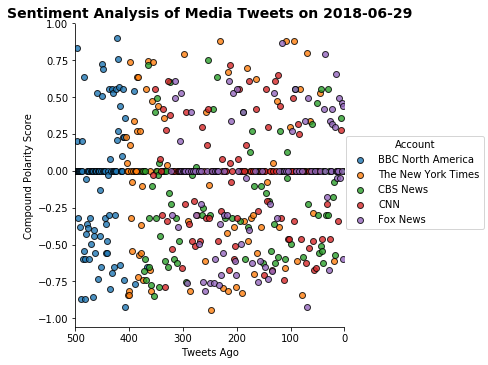

In [9]:
# Use the seaborn 'hue' argument to provide a factor variable
sns.lmplot('Tweets Ago', 'Compound Polarity Score', data=plot_df, fit_reg=False, hue='Account',
           legend=True, legend_out=True, scatter_kws={'linewidths':1,'edgecolor':'k'})

date_searched = max(df['Date'])
plt.title(f'Sentiment Analysis of Media Tweets on {date_searched}', fontsize=14, weight='bold')
# plt.xticks([]) #disable xtick labels of the full date-time because just overlaps all the labels - just rename labels instead
plt.xlim(500, 0) #reverse x-axis so most recent is on right
plt.savefig('file_output\\polarity_scatterplot.png')
plt.show();

### Bar Plot Summary of Overall Average Sentiments
The second plot will be a bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. For this plot, you will again aggregate the compound sentiments analyzed by VADER.

In [10]:
overall_sentiments = df.groupby('Account')[['compound']].mean()
overall_sentiments

,compound
Account,
BBC North America,-0.079994
CBS News,-0.146153
CNN,-0.073063
Fox News,-0.060857
The New York Times,-0.060746


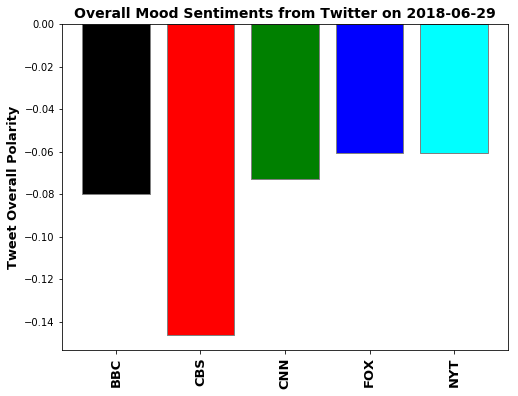

In [11]:
plt.figure(figsize=(8, 6))
#need to shorten names, so when saves image they don't get cut off
plt.bar(['BBC', 'CBS', 'CNN', 'FOX', 'NYT'], overall_sentiments['compound'],
        color=['black', 'red', 'green', 'blue', 'cyan'], edgecolor='gray')

# Add title and axis names
date_searched = max(df['Date'])
plt.title(f'Overall Mood Sentiments from Twitter on {date_searched}', fontsize=14, weight='bold')
#plt.xlabel('News Account')
plt.ylabel('Tweet Overall Polarity', weight='semibold', size=13)

#plt.grid(linestyle='--')
plt.xticks(rotation=90, weight='semibold', size=13)

plt.savefig('file_output\\news_overall_mood.png')
plt.show;